Idealised 2-D viscoelastic loading problem in an annulus
=======================================================

In this tutorial, we examine an idealised 2-D loading problem in an annulus domain.

This example focuses on differences between running simulations in a 2-D annulus
with laterally varying viscosity compared to our
[previous tutorial](../2d_cylindrical), where the viscosity varied as a function
of depth only.

This example
-------------
Let's get started!
The first step is to import the gadopt module, which
provides access to Firedrake and associated functionality.

In [1]:
from gadopt import *
from gadopt.utility import (
    extruded_layer_heights,
    initialise_background_field
)

Let's import the ice sheet disc function from the [last tutorial](../2d_cylindrical)
as well as a helper function to setup the lateral viscosity variations

In [2]:
from gadopt.demos.glacial_isostatic_adjustment.utils import (
    ice_sheet_disc,
    setup_heterogenous_viscosity
)

We also import some helper functions for plotting and making animations associated
with this demo.

In [3]:
from gadopt_demo_utils.gia_demo_utils import (
    plot_ice_ring,
    plot_viscosity,
    plot_animation
)

Similar to our [previous tutorial](../base_case) demo we create the mesh in two
stages. First we create a surface mesh of 180 cells using one of `Firedrake`'s
utility meshes `CircleManifoldMesh` and then we extrude this in the radial
direction by choosing the optional keyword argument `extrusion_type`. As before,
the layer properties specified are from
[Spada et al. (2011)](https://doi.org/10.1111/j.1365-246X.2011.04952.x).
We specify 5 cells per rheological layer so 20 layers in total. To better
represent the curvature of the domain and ensure accuracy of our quadratic
representation of displacement, we approximate the curved cylindrical shell
domain quadratically, using the optional keyword argument `degree`$=2$.

As this problem is not formulated in a Cartesian geometry we set the `mesh.cartesian`
attribute to `False`. This ensures the correct configuration of a radially inward
gravitational direction.

In [4]:
# Set up geometry:
radius_values = [6371e3, 6301e3, 5951e3, 5701e3, 3480e3]
domain_depth = radius_values[0]-radius_values[-1]
radius_values_nondim = np.array(radius_values)/domain_depth

# Construct a circle mesh and then extrude into a cylinder:
ncells = 180
rmin = radius_values_nondim[-1]
surface_mesh = CircleManifoldMesh(ncells, radius=rmin, degree=2, name='surface_mesh')

# Ensure layers of extruded mesh coincide with rheological boundaries
layer_heights = extruded_layer_heights(5, radius_values_nondim)

mesh = ExtrudedMesh(
    surface_mesh,
    layers=len(layer_heights),
    layer_height=layer_heights,
    extrusion_type='radial'
)

mesh.cartesian = False
boundary = get_boundary_ids(mesh)

We next set up the function spaces, and specify functions to hold our solutions.

In [5]:
V = VectorFunctionSpace(mesh, "CG", 2)  # Displacement function space
S = TensorFunctionSpace(mesh, "DQ", 1)  # Stress tensor function space
DG0 = FunctionSpace(mesh, "DQ", 0)  # Density and shear modulus function space
DG1 = FunctionSpace(mesh, "DQ", 1)  # Viscosity function space
R = FunctionSpace(mesh, "R", 0)  # Real function space (for constants)

u = Function(V, name='displacement')
m = Function(S, name="internal variable")

We can output function space information, for example the number of degrees
of freedom (DOF).

In [6]:
log("Number of Displacement DOF:", V.dim())
log("Number of Internal variable DOF:", S.dim())

Number of Displacement DOF: 29520
Number of Internal variable DOF: 57600


We can now visualise the resulting mesh.

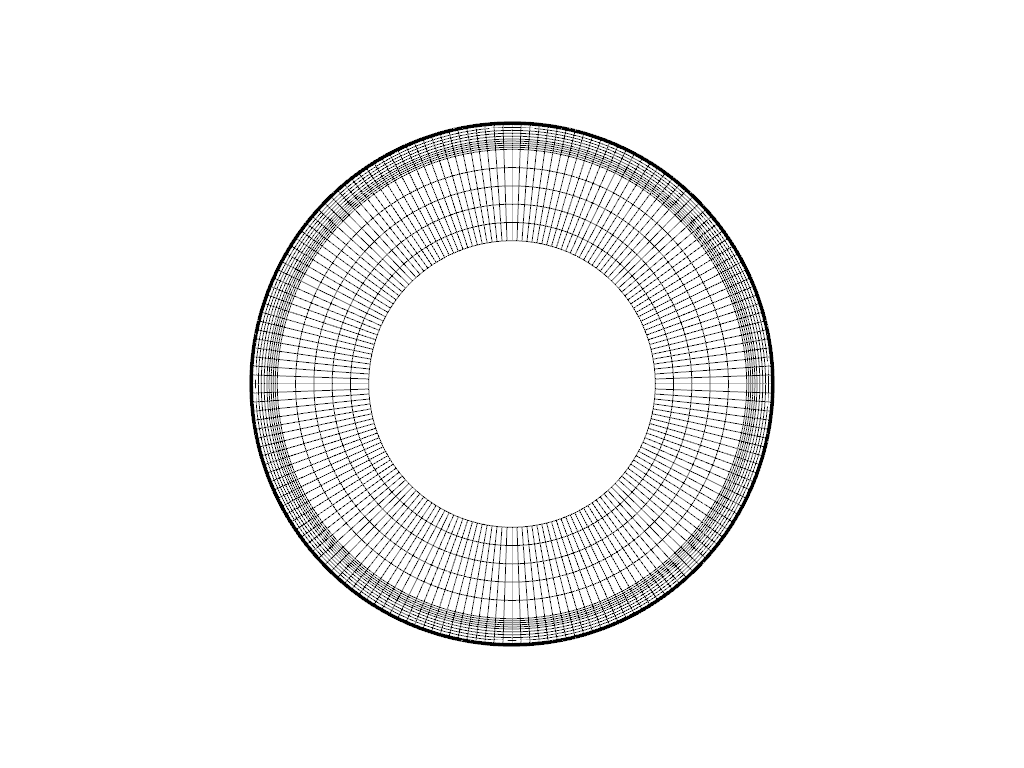

In [7]:
import pyvista as pv
import matplotlib.pyplot as plt

VTKFile("mesh.pvd").write(Function(V))
mesh_data = pv.read("mesh/mesh_0.vtu")
edges = mesh_data.extract_all_edges()
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(edges, color="black")
plotter.camera_position = "xy"
plotter.show(jupyter_backend="static", interactive=False)

Let's start initialising some parameters. First of all let's get the (symbolic)
spatial coordinates of the mesh

In [8]:
X = SpatialCoordinate(mesh)

Now we can set up the background profiles for the material properties.
In this case the density and shear modulus vary in the radial direction.
The layer properties specified are from
[Spada et al. (2011)](https://doi.org/10.1111/j.1365-246X.2011.04952.x)

In [9]:
density_values = [3037, 3438, 3871, 4978]
shear_modulus_values = [0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11]
bulk_shear_ratio = 1.94
viscosity_values = [1e40, 1e21, 1e21, 2e21]

density_scale = 4500
shear_modulus_scale = 1e11
viscosity_scale = 1e21
characteristic_maxwell_time = viscosity_scale / shear_modulus_scale

density_values_nondim = np.array(density_values)/density_scale
shear_modulus_values_nondim = np.array(shear_modulus_values)/shear_modulus_scale
viscosity_values_nondim = np.array(viscosity_values)/viscosity_scale

density = Function(DG0, name="density")
initialise_background_field(
    density, density_values_nondim, X, radius_values_nondim)

shear_modulus = Function(DG0, name="shear modulus")
initialise_background_field(
    shear_modulus, shear_modulus_values_nondim, X, radius_values_nondim)

bulk_modulus = Function(DG0, name="bulk modulus")
initialise_background_field(
    bulk_modulus, shear_modulus_values_nondim, X, radius_values_nondim)

Next let's initialise the viscosity field. In this tutorial we are
going to make things a bit more interesting by using a laterally
varying viscosity field. We'll put some regions of low viscosity
near the South Pole (inspired by West Antarctica) as well as in the lower mantle.
We've also put some relatively higher viscosity patches of mantle in the
northern hemisphere to represent a downgoing slab. We can inspect the
helper function `setup_heterogenous_viscosity` with the code below.

In [10]:
import inspect
print(inspect.getsource(setup_heterogenous_viscosity))

def setup_heterogenous_viscosity(
        X: ufl.geometry.SpatialCoordinate,
        background_viscosity: Function,
        viscosity_scale: float = 1e21,
        r_lith: float = 6301e3,
        domain_depth: float = 2891e3,
) -> Function:
    '''Adds lateral variations to a background viscosity field in a 2D annulus

    The synthetic lateral viscosity variations consist of 5 'blobs'
    constructed from bivariate gaussian functions to represent interesting features
    in the mantle. We assume the background viscosity only varies in the
    radial direction and do not make modifications to the viscosity structure
    in the lithosphere i.e. for r > `r_lith' where r is the radial distance.

    Args:
      X:
        Spatial coordinate associated with the mesh
      background_viscosity:
        Background radial viscosity field (N.b. this is not modified)
      viscosity_scale:
        Characteristc viscosity used for nondimensionalisation
      r_lith:
        Radius of the lithosp

To better represent the spatially varying viscosity field let's use a linear
discontinuous Galerkin space, `DG1`, i.e. the viscosity fields varies linearly
within cells but can have jumps in between cells.

In [11]:
background_viscosity = Function(DG1, name="background viscosity")
initialise_background_field(
    background_viscosity, viscosity_values_nondim, X, radius_values_nondim)

viscosity = setup_heterogenous_viscosity(X, background_viscosity)

We'll keep the same ice synthetic ice sheet configuration as in the
[previous tutorial](../2d_cylindrical). Let's put one a larger one over the South
Pole, with a total horizontal extent of 40 $^\circ$ and a maximum thickness of
2 km, and a smaller one offset from the North Pole with a width of 20 $^\circ$
and a maximum thickness of 1 km. To simplify things we keep the ice load fixed in
time.

In [12]:
# Initialise ice loading
rho_ice = 931 / density_scale
g = 9.815
B_mu = Constant(density_scale * domain_depth * g / shear_modulus_scale)
log("Ratio of buoyancy/shear = rho g D / mu = ", float(B_mu))
Hice1 = 1000 / domain_depth
Hice2 = 2000 / domain_depth

# Setup a disc ice load but with a smooth transition given by a tanh profile
disc_centre1 = (2*pi/360) * 25  # Centre of disc 1 in radians
disc_centre2 = pi  # Centre of disc 2 in radians
disc_halfwidth1 = (2*pi/360) * 10  # Disc 1 half width in radians
disc_halfwidth2 = (2*pi/360) * 20  # Disc 2 half width in radians
disc1 = ice_sheet_disc(X, disc_centre1, disc_halfwidth1)
disc2 = ice_sheet_disc(X, disc_centre2, disc_halfwidth2)
ice_load = B_mu * rho_ice * (Hice1 * disc1 + Hice2 * disc2)

Ratio of buoyancy/shear = rho g D / mu =  1.276882425


As before let's visualise the viscosity field and ice thickness using pyvista.

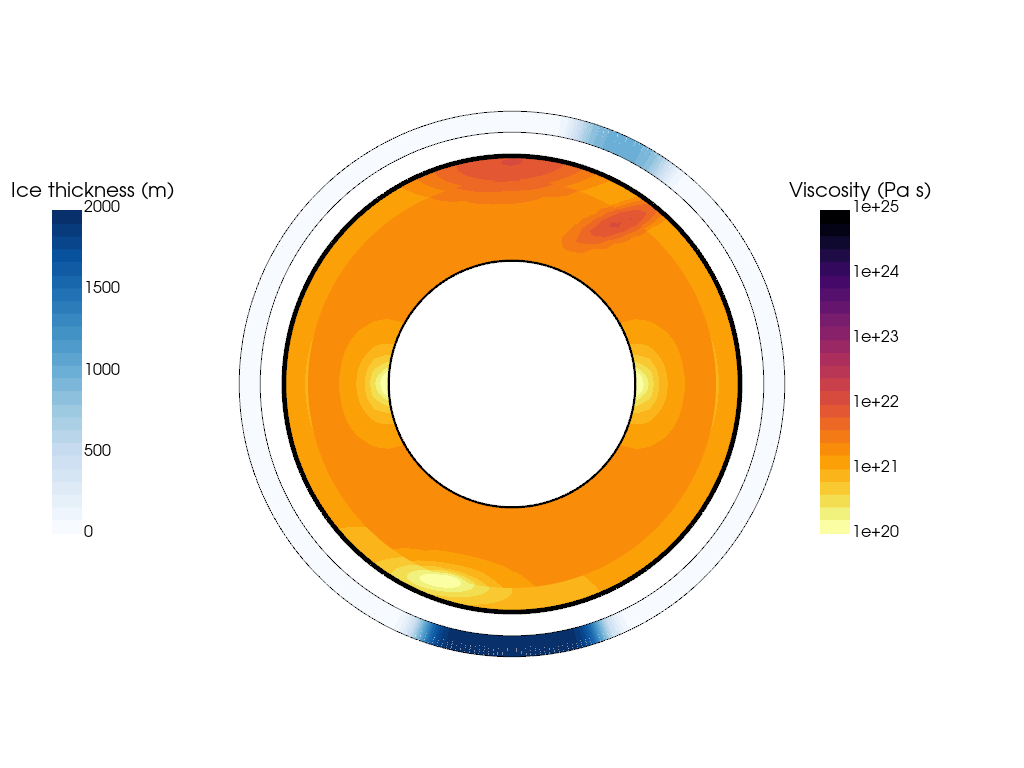

In [13]:
# Write ice thicknesss .pvd file
P1 = FunctionSpace(mesh, "CG", 1)  # Continuous function space
ice_thickness = Function(P1, name="Ice thickness").interpolate(Hice1 * disc1 + Hice2 * disc2)
zero_ice_thickness = Function(P1, name="zero").assign(0)  # Used for plotting later
ice_thickness_file = VTKFile('ice.pvd').write(ice_thickness, zero_ice_thickness)
visc_file = VTKFile('viscosity.pvd').write(viscosity)

# Create a plotter object
plotter = pv.Plotter(shape=(1, 1), border=False, notebook=True, off_screen=False)
plot_ice_ring(plotter)
plot_viscosity(plotter)
plotter.camera_position = 'xy'
plotter.show(jupyter_backend="static", interactive=False)
plotter.close()

Let's setup the timestepping parameters with a timestep of 250 years and an output
frequency of 1000 years.

In [14]:
# Timestepping parameters
Tstart = 0
year_in_seconds = 3600*24*365.25
time = Function(R).assign(Tstart * year_in_seconds)

dt_years = 250
dt = Constant(dt_years * year_in_seconds/characteristic_maxwell_time)
Tend_years = 10e3
Tend = Constant(Tend_years * year_in_seconds/characteristic_maxwell_time)
dt_out_years = 1e3
dt_out = Constant(dt_out_years * year_in_seconds/characteristic_maxwell_time)

max_timesteps = round((Tend - Tstart * year_in_seconds/characteristic_maxwell_time) / dt)

output_frequency = round(dt_out / dt)

We can now define the boundary conditions to be used in this simulation. For the
top surface we need to specify a normal stress, i.e. the weight of the ice load,
as well as indicating this is a free surface.

In [15]:
# Setup boundary conditions
stokes_bcs = {boundary.top: {'free_surface': {'normal_stress': ice_load}},
              boundary.bottom: {'un': 0}
              }

We also need to specify a G-ADOPT approximation which sets up the various parameters
and fields needed for the viscoelastic loading problem.

In [16]:
approximation = MaxwellApproximation(
    bulk_modulus=bulk_modulus,
    density=density,
    shear_modulus=shear_modulus,
    viscosity=viscosity,
    B_mu=B_mu,
    bulk_shear_ratio=bulk_shear_ratio)

As noted above, with a free-slip boundary condition on both boundaries, one can add
an arbitrary rotation of the form $(-y, x)=r\hat{\mathbf{\theta}}$ to the displacement
solution. These lead to null-modes (eigenvectors) for the linear system, rendering
the resulting matrix singular. In preconditioned Krylov methods these null-modes
must be subtracted from the approximate solution at every iteration. We do that
below, setting up a nullspace object, specifying the `rotational` keyword argument
to be True.

In [17]:
V_nullspace = rigid_body_modes(V, rotational=True)

We finally come to solving the variational problem, with solver
objects for the Stokes system created. We pass in the solution field `u` and
various fields needed for the solve along with the approximation, timestep,
list of internal variables, boundary conditions and nullspaces.

In [18]:
stokes_solver = InternalVariableSolver(
    u,
    approximation,
    dt=dt,
    internal_variables=m,
    bcs=stokes_bcs,
    constant_jacobian=True,
    nullspace=V_nullspace,
)

We next set up our output in VTK format and the the logging file using `GeodynamicalDiagnostics` as before.

In [19]:
# Create a velocity function for plotting
velocity = Function(u, name="velocity")
disp_old = Function(u, name="old_disp").assign(u)
# Create output file
output_file = VTKFile("output.pvd")
output_file.write(u, m, velocity)

plog = ParameterLog("params.log", mesh)
plog.log_str(
    "timestep time dt u_rms u_rms_surf uv_min"
)

checkpoint_filename = "viscoelastic_loading-chk.h5"

gd = GeodynamicalDiagnostics(u, bottom_id=boundary.bottom, top_id=boundary.top)

Although not necessary for this demo let's checkpoint the displacement and
velocity fields at each timestep so that we can use them in our adjoint ice demo.

In [20]:
objective_checkpoint_file = "forward-2d-cylindrical-disp-vel.h5"
obj_chk = CheckpointFile(objective_checkpoint_file, 'w')
obj_chk.save_mesh(mesh)

Now let's run the simulation! At each step we call `solve` to calculate the
displacement pressure field and update the internal variable accounting for
the stress relaxation in the time dependent viscoelastic constitutive equation.

In [21]:
for timestep in range(1, max_timesteps+1):

    time.assign(time+dt)
    stokes_solver.solve()

    # Log diagnostics:
    plog.log_str(f"{timestep} {time} {float(dt)} {gd.u_rms()} "
                 f"{gd.u_rms_top()} {gd.ux_max(boundary.top)} "
                 f"{gd.uv_min(boundary.top)}"
                 )

    velocity.interpolate((u - disp_old)/dt)
    disp_old.assign(u)

    # checkpoint solution state for objective function in adjoint ice demo
    obj_chk.save_function(u, name="displacement", idx=timestep)
    obj_chk.save_function(velocity, name="velocity", idx=timestep)

    if timestep % output_frequency == 0:
        log("timestep", timestep)

        output_file.write(u, m, velocity)

        with CheckpointFile(checkpoint_filename, "w") as checkpoint:
            checkpoint.save_function(u, name="displacement")
            checkpoint.save_function(m, name="internal variable")

plog.close()
obj_chk.close()

timestep 4


timestep 8


timestep 12


timestep 16


timestep 20


timestep 24


timestep 28


timestep 32


timestep 36


timestep 40


Let's use the python package *PyVista* to plot the magnitude of the displacement
field through time. We will use the calculated displacement to artifically scale
the mesh. We have exaggerated the stretching by a factor of 1500, **BUT...**
it is important to remember this is just for ease of visualisation - the mesh
is not moving in reality!

In [22]:
# Create a plotter object
plotter = pv.Plotter(shape=(1, 1), border=False, notebook=True, off_screen=False)
plot_animation(plotter)
plotter.close()

Step:  0


Step:  1


Step:  2


Step:  3


Step:  4


Step:  5


Step:  6


Step:  7


Step:  8


Step:  9


Step:  10


Looking at the animation, we can see that the weight of the ice load deforms the
mantle, sinking beneath the ice load and pushing up material away from the ice
load. This forebulge grows through the simulation and by 10,000 years is close
to isostatic equilibrium. As the ice load is applied instantaneously the highest
velocity occurs within the first timestep and gradually decays as the simulation
goes on, though there is still a small amount of deformation ongoing after
10,000 years. We can also clearly see that the lateral viscosity variations
give rise to asymmetrical displacement patterns. This is especially true near
the South Pole, where the low viscosity region has enabled the isostatic
relaxation to happen faster than the surrounding regions.

![SegmentLocal](displacement_warp.gif "segment")